# CARGA DE DATOS

__TODO__

In [1]:
from Utils import DatasetProcess, reconstruction_plot
from ConvModel import ConvModel
from AutoEncoder import TwoStepAutoEncoder, TwoStepClassifier, TwoStepTraining, OneStepAutoencoder, OneStepTraining
from OneClass import AnomalyDetector
from Contrastive import ContrastiveModel

2025-04-02 21:10:44.766415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743621044.777450  160541 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743621044.780845  160541 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743621044.790433  160541 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743621044.790443  160541 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743621044.790444  160541 computation_placer.cc:177] computation placer alr

In [2]:
(x_train, y_train), (x_test, y_test) = DatasetProcess.load()


# Aplicar la función hold_out
(x_train_no_labeled, x_train_labeled, y_train_labeled), (x_val, y_val), (x_test, y_test) = DatasetProcess.hold_out(
    (x_train, y_train), (x_test, y_test), validation_size=1000
)

x_train_labeled = x_train_labeled.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Verificar las dimensiones
print(f"Datos no etiquetados: {x_train_no_labeled.shape}")
print(f"Datos etiquetados entrenamiento: {x_train_labeled.shape}")
print(f"Etiquetas entrenamiento: {y_train_labeled.shape}")
print(f"Datos validación: {x_val.shape}")
print(f"Etiquetas validación: {y_val.shape}")
print(f"Datos prueba: {x_test.shape}")
print(f"Etiquetas prueba: {y_test.shape}")

Datos no etiquetados: (40000, 32, 32, 3)
Datos etiquetados entrenamiento: (9000, 32, 32, 3)
Etiquetas entrenamiento: (9000, 1)
Datos validación: (1000, 32, 32, 3)
Etiquetas validación: (1000, 1)
Datos prueba: (10000, 32, 32, 3)
Etiquetas prueba: (10000, 1)


# EJERCICIO 1

Entrena un modelo, creado sobre TensorFlow, haciendo uso únicamente de las instancias etiquetadas de entrenamiento. Dicho modelo debe de tener al menos cuatro capas densas y/o convolucionales.

Responde a las siguientes preguntas:

1. ¿Qué red has escogido? ¿Por qué? ¿Cómo la has entrenado?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Qué conclusiones sacas de los resultados detallados en el punto anterior?

In [3]:
model_base = ConvModel()
history_base = model_base.fit(
    x_train_labeled, 
    y_train_labeled,
    validation_data=(x_val, y_val),
    batch_size=64,
    epochs=100
)

/home/clown/2-semester/3year2sem/maai/maai_env/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1743621049.274816  160541 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9541 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:06:00.0, compute capability: 8.6
/home/clown/2-semester/3year2sem/maai/maai_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


E0000 00:00:1743621054.268517  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1743621055.999734  160665 cuda_dnn.cc:529] Loaded cuDNN version 90501


141/141 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.0274 - loss: 9.5252 - val_accuracy: 0.0130 - val_loss: 9.6815
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0588 - loss: 7.9235 - val_accuracy: 0.0090 - val_loss: 7.8569
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0673 - loss: 6.7136 - val_accuracy: 0.0200 - val_loss: 6.6847
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0743 - loss: 5.9621 - val_accuracy: 0.0500 - val_loss: 5.8900
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.0962 - loss: 5.4407 - val_accuracy: 0.0820 - val_loss: 5.3838
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.0955 - loss: 5.1469 - val_accuracy: 0.0750 - val_loss: 5.3943
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1128 - loss: 4.8846 - val_accuracy: 0.0820 - val_loss: 5.0143
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1207 - loss: 4.6932 - val_accurac

In [4]:
# Evalúa con el conjunto de prueba
test_accuracy = model_base.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3146 - loss: 3.3181
Accuracy en conjunto de prueba: 0.311599999666214


In [7]:
import numpy as np
np.unique(np.argmax(model_base(x_test),axis=1)) # >> array([60]) # solo predice la clase 60

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

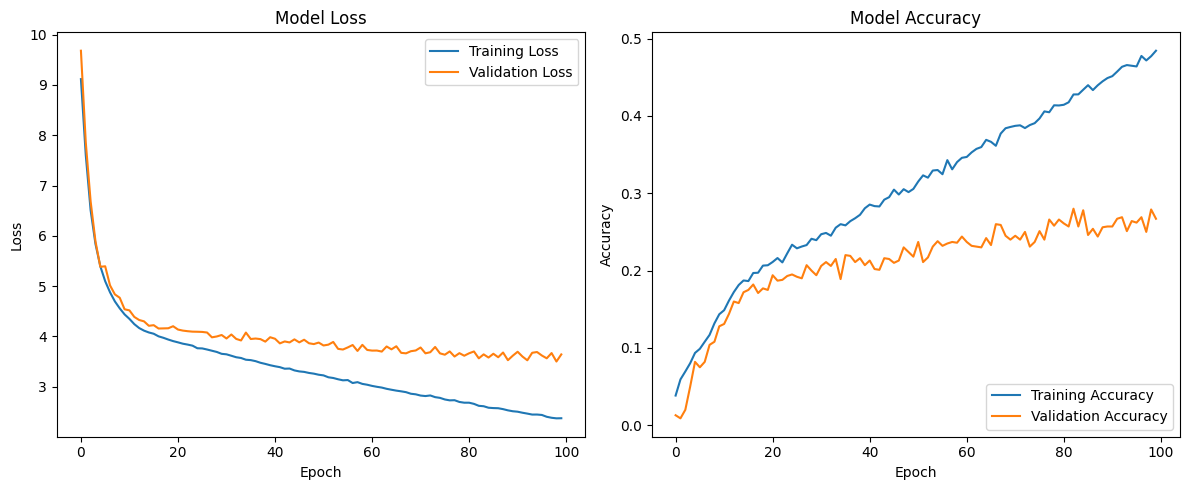

In [6]:
model_base.plot(history_base)

# EJERCICIO 2

Entrena el mismo modelo, incorporando las instancias no etiquetadas de entrenamiento mediante la técnica de auto-aprendizaje. Opcionalmente, se ponderará cada instancia de entrada en función de su calidad (o certeza).

Responde a las siguientes preguntas:
1. ¿Qué parámetros has definido para el entrenamiento?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en el Ejercicio 1?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
# Función para crear modelos consistentes durante self-training
def create_model():
    return ConvModel(
        learning_rate=0.0005,  # Learning rate reducido para fine-tuning
        dropout_prob=0.25,     
        l2_lambda=0.005        
    )

# Normalizar datos no etiquetados
x_train_no_labeled = x_train_no_labeled.astype('float32') / 255.0

# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train_labeled,
    y_train=y_train_labeled,  
    unlabeled_data=x_train_no_labeled,
    validation_data=(x_val, y_val),
    thresh=0.9,             # Umbral ligeramente más bajo para incluir más ejemplos
    train_epochs=5           # 5 iteraciones de self-training
)

# Evalúa el modelo final
final_accuracy = final_model.score(x_test, y_test)
print(f"Accuracy del modelo final con self-training: {final_accuracy}")
print(f"Mejora respecto al modelo base: {final_accuracy - test_accuracy:.4f}")

/home/clown/2-semester/3year2sem/maai/maai_env/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/clown/2-semester/3year2sem/maai/maai_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


E0000 00:00:1743621626.286894  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_5_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.0294 - loss: 17.4363
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.0612 - loss: 14.5111
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.0763 - loss: 12.3639
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0872 - loss: 11.2267
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1017 - loss: 10.4120
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1103 - loss: 9.8899
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1142 - loss: 9.5124
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1268 - loss: 9.1934
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.1513 - loss: 8.8315
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1622 - loss: 8.6186
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1762 - loss: 8.3592
Epoch 12/100
141/141 ━━━━━━━━━━━━━━━

E0000 00:00:1743622149.519596  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_10_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.0808 - loss: 15.4414
Epoch 2/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1426 - loss: 11.9339
Epoch 3/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.1674 - loss: 9.9073
Epoch 4/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2040 - loss: 8.8446
Epoch 5/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.2339 - loss: 8.2016
Epoch 6/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.2575 - loss: 7.6915
Epoch 7/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.2893 - loss: 7.3053
Epoch 8/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3051 - loss: 7.0013
Epoch 9/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3294 - loss: 6.7799
Epoch 10/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3514 - loss: 6.5238
Epoch 11/100
187/187 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3505 - loss: 6.4818
Epoch 12/100
187/187 ━━━━━━━━━━━━━━━━━━

E0000 00:00:1743622825.918368  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


227/227 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.0888 - loss: 14.5595
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.1736 - loss: 10.5811
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.2160 - loss: 8.6738
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.2605 - loss: 7.7181
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.2802 - loss: 7.1129
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3218 - loss: 6.6184
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3650 - loss: 6.1945
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.3892 - loss: 5.9630
Epoch 9/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4012 - loss: 5.8321
Epoch 10/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4173 - loss: 5.7109
Epoch 11/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.4224 - loss: 5.6194
Epoch 12/100
227/227 ━━━━━━━━━━━━━━━━━━

E0000 00:00:1743623645.879340  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


269/269 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0870 - loss: 13.8838
Epoch 2/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.1768 - loss: 9.4345
Epoch 3/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.2201 - loss: 7.7006
Epoch 4/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.2608 - loss: 6.8083
Epoch 5/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3111 - loss: 6.2817
Epoch 6/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.3578 - loss: 5.8255
Epoch 7/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.3876 - loss: 5.5539
Epoch 8/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4066 - loss: 5.3912
Epoch 9/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.4184 - loss: 5.2479
Epoch 10/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.4215 - loss: 5.2155
Epoch 11/100
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4387 - loss: 5.1117
Epoch 12/100
269/269 ━━━━━━━━━━━━━━━━

E0000 00:00:1743624625.379822  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


306/306 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.0978 - loss: 13.4407
Epoch 2/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.1961 - loss: 8.7748
Epoch 3/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.2481 - loss: 7.0645
Epoch 4/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.2997 - loss: 6.2296
Epoch 5/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.3410 - loss: 5.7073
Epoch 6/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.3887 - loss: 5.3521
Epoch 7/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4206 - loss: 5.1434
Epoch 8/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4279 - loss: 5.0044
Epoch 9/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4376 - loss: 4.9231
Epoch 10/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.4482 - loss: 4.8276
Epoch 11/100
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4497 - loss: 4.7730
Epoch 12/100
306/306 ━━━━━━━━━

E0000 00:00:1743625738.532072  160541 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.1032 - loss: 12.8723 - val_accuracy: 0.0120 - val_loss: 9.1114
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.2084 - loss: 8.1182 - val_accuracy: 0.0730 - val_loss: 6.2579
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.2527 - loss: 6.5761 - val_accuracy: 0.1120 - val_loss: 5.5243
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.3109 - loss: 5.8209 - val_accuracy: 0.1390 - val_loss: 5.0858
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3561 - loss: 5.3449 - val_accuracy: 0.1500 - val_loss: 4.9805
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4090 - loss: 4.9717 - val_accuracy: 0.1750 - val_loss: 4.7839
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4256 - loss: 4.8144 - val_accuracy: 0.1710 - val_loss: 4.7864
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4371 - loss: 4.7212 - val

# EJERCICIO 3

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en dos pasos (primero el autoencoder, después el clasificador). La arquitectura del encoder debe ser exactamente la misma que la definida en los Ejercicios 1 y 2, a excepción del último bloque de capas.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los Ejercicios 1 y 2?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [4]:
autoencoder = TwoStepAutoEncoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0015)
classifier = TwoStepClassifier()

In [ ]:
TwoStepTraining(autoencoder=autoencoder, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                batch_size_autoencoder=256,
                epochs_autoencoder=15,
                batch_size_classifier=4096,
                epochs_classifier=405)

In [ ]:
reconstruction_plot(autoencoder, x_test)

In [ ]:
autoencoder.score(x_test)

# EJERCICIO 4

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en un paso (autoencoder y clasificador al mismo tiempo). La arquitectura del autoencoder será la misma que la definida en el Ejercicio 3, y la combinación de encoder y clasificador será igual a la arquitectura definida en el
Ejercicio 1.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los ejercicios anteriores?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [4]:
one_step_autoencoder = OneStepAutoencoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0015,
                                decoder_extra_loss_weight = 0.3)

In [ ]:
h = OneStepTraining(one_step_autoencoder, 
                    x_train=x_train, 
                    y_train=one_hot_train, 
                    unlabeled_train=unlabeled_train,
                    batch_size=256,
                    epochs=3)

In [ ]:
reconstruction_plot(one_step_autoencoder, x_test)

In [ ]:
one_step_autoencoder.score(x_test)

# EJERCICIO 5

Repite el mismo entrenamiento de los Ejercicios 1-4, pero eliminando las instancias no etiquetadas
más atípicas con respecto a los datos etiquetados. Se cumplirán los siguientes puntos:
- La arquitectura de la red de clasificación en una clase será la misma a la utilizada en el
clasificador del Ejercicio 1, a excepción de la capa de salida.
- Utiliza la técnica explicada en el Notebook 5, usando un valor de 𝑣 = 0,9.

Responde a la siguiente pregunta:
1. ¿Se mejoran los resultados con respecto a los anteriores ejercicios? ¿Qué conclusiones sacas de estos resultados?

In [ ]:
model = AnomalyDetector(input_shape=(32,32,3), 
                        nu=.9,
                        l2_lambda=0.0,
                        learning_rate=0.0001,
                        dropout_prob=0.1)
model.fit(x_train, 
          batch_size=256, 
          epochs=50, 
          delta=.025, 
          steps=100)

In [ ]:
import numpy as np

# TODO: Evalúa el modelo con los datos del conjunto de test. Indica el porcentaje de datos etiquetados como típicos, y visualiza los datos
predicciones = model.predict(x_test)

# Determinamos qué datos son típicos (normales) y cuáles son anomalías
# Un dato es típico si su predicción es mayor que r
r_valor = model.model.r.numpy()
es_tipico = predicciones > r_valor

# Calculamos el porcentaje de datos etiquetados como típicos
porcentaje_tipicos = np.mean(es_tipico) * 100

print(f"Valor de r: {r_valor:.4f}")
print(f"Porcentaje de datos etiquetados como típicos: {porcentaje_tipicos:.2f}%")
print(f"Porcentaje de datos etiquetados como anomalías: {100 - porcentaje_tipicos:.2f}%")

In [ ]:
np.unique(predicciones)

In [ ]:
# TODO: Evalúa el modelo con los datos del conjunto de outliers. Indica el porcentaje de datos etiquetados como atípicos, y visualiza los datos en conjunto con los de test
predicciones_outliers = model.predict(x_outliers)
r_valor = model.model.r.numpy()
es_atipico_outliers = predicciones_outliers <= r_valor
porcentaje_atipicos_outliers = np.mean(es_atipico_outliers) * 100

# Evaluamos también los datos de test para comparar
predicciones_test = model.predict(x_test)
es_atipico_test = predicciones_test <= r_valor

print(f"Porcentaje de outliers etiquetados como atípicos: {porcentaje_atipicos_outliers:.2f}%")

# EJERCICIO 6

Repite los Ejercicios 3-5 cambiando el autencoder por la técnica definida en el apartado “Hay vida más allá del autoencoder” del Notebook 4. Contesta a las preguntas de dichos ejercicios. Se cumplirán los siguientes puntos:

1. La arquitectura de la red será igual a la parte encoder del autencoder definido en los
ejercicios anteriores.
2. El modelo debe entrenar correctamente.

In [ ]:
cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001)
cModel.train(unlabeled_train, 
             epochs=5, 
             batch_size=2048)
cModel.plot_training_history()

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cModel.plot_similarity_matrix(test_samples, n_samples=n_samples);